In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np

plt.style.use("ggplot")

# Compare RADR modelled discharge to observed data for major Arctic rivers and area-scale ArcticGRO

In this notebook, we compare daily and monthly RADR and observed (ArcticGRO) discharge data, after first area-scaling the ArcticGRO data. From this exploration, I have decided for starters to directly replace RADR data with ArcticGRO observations for the big 6 rivers. The Yukon has a data gap, so that data gap will be RADR rather than ArcticGRO, but all other rivers have complete series.

**Future improvements** would be to explore:

* Bias-correcting RADR using observed data for all the other rivers. Some kind of month-by-month correction factor.
* Also replacing RADR data with observations, when available
* Downloading extra data (e.g. from the GDRC data portal)

If time allows, I'll come back to this, or in future projects.

# Compare daily RADR and ArcticGRO data

In [2]:
df = pd.read_csv(r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_vs_ArcticGRO.csv", index_col=0)
df.head()

,date,site,q_m3ps_obs,q_m3ps_radr,month
3288,1993-01-01,Indigirka,4.62,79.848,1
3289,1993-01-02,Indigirka,4.48,78.030,1
3290,1993-01-03,Indigirka,4.34,76.291,1
3291,1993-01-04,Indigirka,4.20,74.625,1
3292,1993-01-05,Indigirka,4.06,73.029,1


## Read in ArcticGRO and RADR catchment areas and area-scale ArcticGRO

In [3]:
obs_loc_shp = r"/home/jovyan/shared/pan_arctic_data/ArcticGRO_spatial_data/sampling_locations_discharge_one-site-per-riv.shp"
gdf = gpd.read_file(obs_loc_shp).set_index('River')
gdf

,Sampling_l,Lat,Lon,Collection,data_downl,area_STN_k,area_GRDC_,ContPerma_,ContDiscon,popdensity,comment,NameTidy,OutCOMID,radr_area_,geometry
River,,,,,,,,,,,,,,,
Yukon,Pilot Station,61.93,-162.88,USGS,1,850596,831390,19.0,87.0,0.2,None,Yukon,81020021,8.362082e+05,POINT (6124999.301 4816953.001)
Mackenzie,Arctic Red River,67.45,-133.74,Water Survery of Canada,1,1678481,1660000,13.0,42.0,0.2,None,Mackenzie,82000867,1.791398e+06,POINT (4662256.962 4890571.113)
Ob',Salekhard,66.63,66.60,Roshydromet,1,2533000,2950000,1.0,4.0,8.0,None,Ob,31006084,2.945383e+06,POINT (4547667.559 138911.561)
Yenisey,Igarka,67.43,86.48,Roshydromet,1,2413000,2440000,31.0,42.0,3.0,None,Yenisey,32000794,2.569614e+06,POINT (5311240.594 484778.545)
Lena,Kyusyur,70.68,127.39,Roshydromet,1,2430000,2430000,77.0,90.0,0.4,kyusyur not in GRDC database. Area from https:...,Lena,34000655,2.464300e+06,POINT (6074074.943 1857686.726)
Kolyma,Kolymskoe,68.73,158.72,Roshydromet,1,536000,526000,99.0,100.0,0.1,None,Kolyma,35006945,6.531339e+05,POINT (6373420.329 2985244.110)
Onega,Porog,63.82,38.47,Roshydromet,1,56600,55800,NaN,NaN,NaN,None,Onega,26012382,5.670564e+04,POINT (3255879.663 -35299.271)
Northern Dvina,Ust' Pinega,64.13,41.92,Roshydromet,1,358000,348000,NaN,NaN,NaN,None,NorthernDvina,26009829,3.553120e+05,POINT (3423718.573 -53635.399)
Mezen',Malonisogorskoye,65.01,45.62,Roshydromet,1,56500,56400,NaN,NaN,NaN,None,Mezen,26007409,7.525720e+04,POINT (3615174.331 -3257.042)


In [4]:
# Get a list of river names for looping
rivers_li = list(df['site'].unique())
rivers_li

['Indigirka',
 'Pechora',
 'Pur',
 'Kolyma',
 'Yenisey',
 'Ob',
 'NorthernDvina',
 'Olenek',
 'Yana',
 'Mackenzie',
 'Mezen',
 'Nadym',
 'Yukon',
 'Lena',
 'Onega']

In [5]:
# Rename rivers in geodataframe so they match the dataframe
gdf.rename({"Ob'": "Ob", "Northern Dvina": "NorthernDvina", "Mezen'": "Mezen"}, inplace=True)

### Area-scale ArcticGRO

Area-scale so that we have an estimate of observations at the catchment-to-sea outflow point (i.e. where RADR Q is estimated).

Areas for the ArcticGRO catchments were generally looked up manually from the station attributes presented in the "UNH-GRDC Composite Runoff Fields V1.0" (https://www.compositerunoff.sr.unh.edu/index.html). Two areas are given in this dataset, the upstream area of the GRDC station and the so-called STN area. The latter is the estimated catchment area according the Simulated Topological Network used in the Composite Runoff modelling. The STN derived catchment area is typically fairly close to the reported catchment area, but STN includes the potential area (including the topography), and so can be different where this differs from the actively-flowing portion of the river basin. Having considered the two, decide to use the GRDC areas, as more standard. For the Ob, also then have the same catchment sizes for RADR and ArcticGRO.

**NOTE** I haven't taken travel times into account with this area-scaling. i.e. depending on how far the gauging station is from the coast, we might expect a delay of a few days or longer before water reaches the catchment outflow at the coast. Given our main interest is in a monthly mean, I think this is ok (I took it into account for the QC regressions, as matching parcels of water was more important there).

In [6]:
agro_area = 'area_GRDC_'  # km2

df['q_obs_scaled_m3ps'] = np.NaN
for river in rivers_li:
    q_original = df.loc[df['site'] == river, 'q_m3ps_obs']
    q_scaled = q_original * gdf['radr_area_'][river]/gdf[agro_area][river]
    q_scaled = q_scaled.values
    df.loc[df['site'] == river, 'q_obs_scaled_m3ps'] = q_scaled

In [7]:
# Quick check of scaling
site = "Ob"
df.query("site == @site").head()

,date,site,q_m3ps_obs,q_m3ps_radr,month,q_obs_scaled_m3ps
63920,1984-01-01,Ob,7130.0,8952.445,1,7118.841722
63921,1984-01-02,Ob,7140.0,8952.441,1,7128.826072
63922,1984-01-03,Ob,7160.0,8870.441,1,7148.794773
63923,1984-01-04,Ob,7180.0,8787.366,1,7168.763473
63924,1984-01-05,Ob,7200.0,8703.270,1,7188.732174


## Plot comparing daily obs and sim

In [8]:
# # Scatter plot with points coloured by month
# sn.lmplot(
#     data=df,
#     x="q_obs_scaled_m3ps",
#     y="q_m3ps_radr",
#     hue="month",
#     fit_reg=False,
#     col="site",
#     col_wrap=3,
#     aspect=1,
#     facet_kws={"sharex": False, "sharey": False},
# )

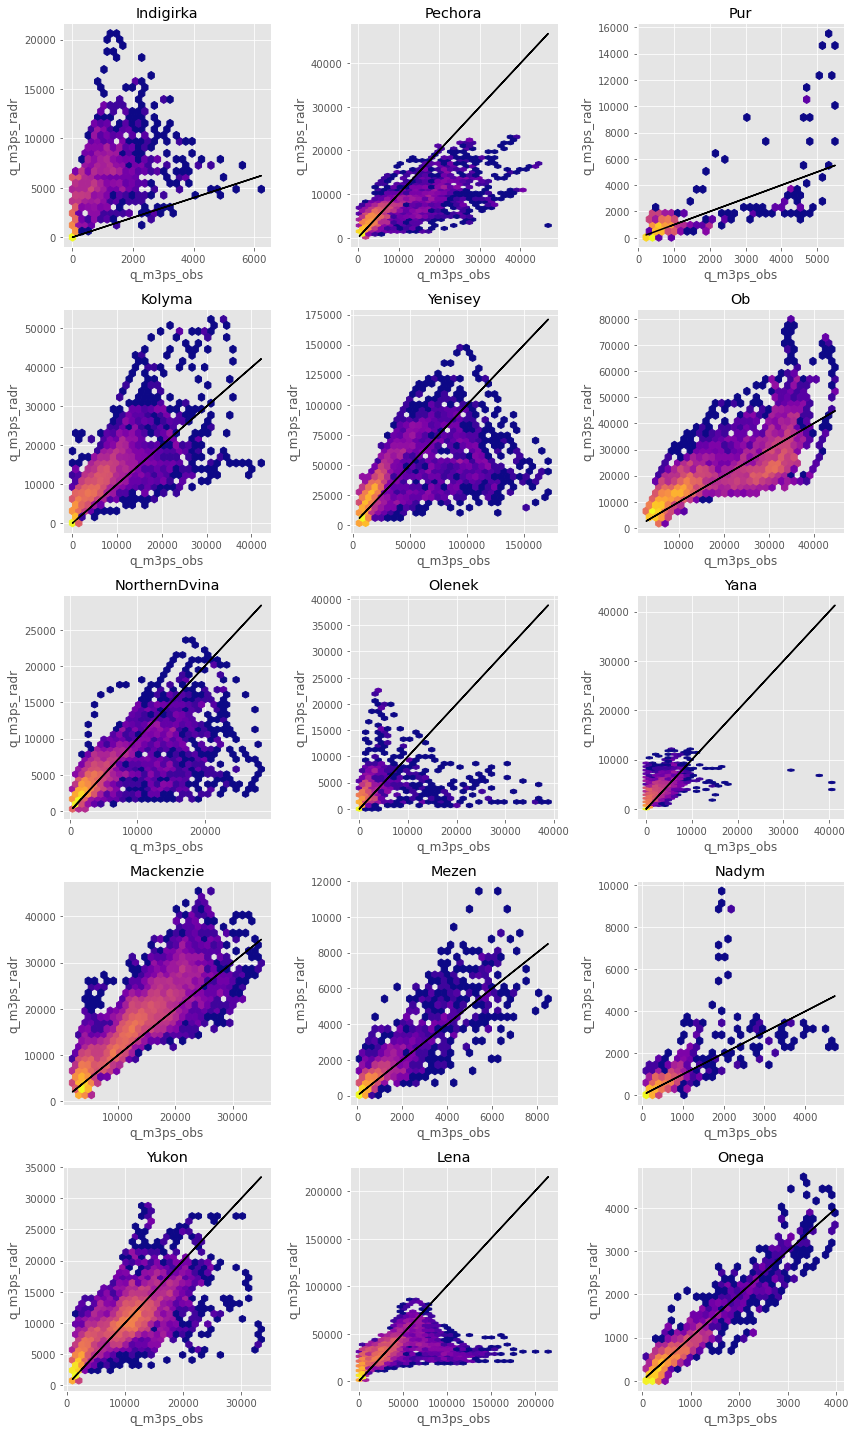

In [9]:
# Hexbin plot to reduce noise
# obs = "q_obs_scaled_m3ps"
obs = 'q_m3ps_obs'
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))
axes = axes.flatten()

for idx, site in enumerate(rivers_li):
    df2 = df.query("site == @site")
    axes[idx].hexbin(
        data=df2,
        x=obs,
        y="q_m3ps_radr",
        gridsize=30,
        bins="log",
        cmap="plasma",
    )
    axes[idx].plot(df2[obs], df2[obs], "k-")
    axes[idx].set_title(site)
    axes[idx].set_xlabel(obs)
    axes[idx].set_ylabel("q_m3ps_radr")

# plt.suptitle("RADR vs area-scaled ArcticGRO daily Q")
plt.tight_layout()
plt.savefig("/home/jovyan/BEST-Siberian/output/analysis/plots/compare_q_radr_obs/radr_obs_daily_hexbin")

From visual inspection it's hard to say whether the area-scaling improves things. Perhaps a bit for the Kolyma, but for the rest would need to look at e.g. regressions to say anything meaningful. However, it should be more hydrologically correct, although the assumption that the same climate applies downstream of the monitoring site as upstream is probably not true (the ungauged portion of the catchment is higher latitude).

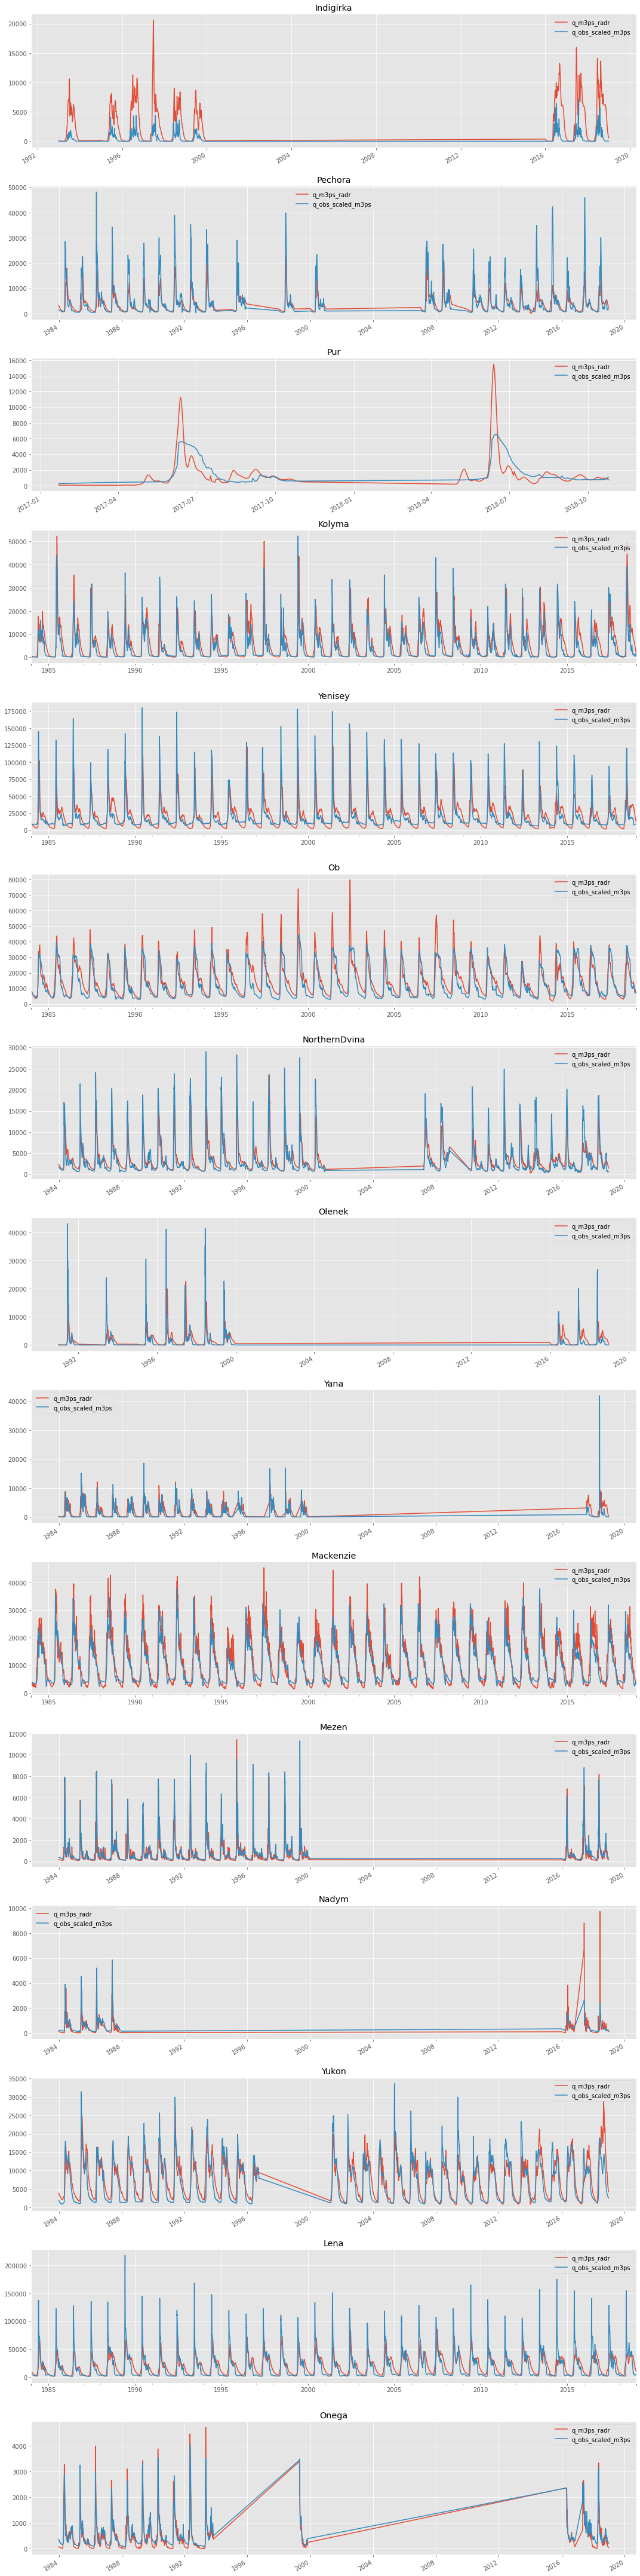

In [10]:
# Timeseries
fig, axes = plt.subplots(nrows=len(rivers_li), ncols=1, figsize=(15, 60))

for idx, site in enumerate(rivers_li):
    ax = axes[idx]
    df2 = df.loc[df['site'] == site, ['date', 'q_m3ps_radr', 'q_obs_scaled_m3ps']]

    df2 = df2.set_index('date')
    df2.index = pd.to_datetime(df2.index)

    df2.plot(ax=ax)

    ax.set_title(site)
    ax.xaxis.label.set_visible(False)

plt.tight_layout()
plt.show()

From these plots, I have decided to drop Pur and Nadym (too little data) and Indigirka (the ArcticGRO station is a long way from sea, and there is some uncertainty relating to its exact location).

For all the others, need to look a little closer and decide whether it's worth faffing around replacing RADR with ArcticGRO. I think it is for the big 6, which basically have complete records, given sometimes quite large differences between RADR and obs. But perhaps it won't be for the others, unless I also do some kind of bias correction of the RADR data.

In [11]:
# Remove unwanted sites from the site list for further processing
drop_sites = ['Indigirka', 'Pur', 'Nadym']
rivers_li = [x for x in rivers_li if x not in drop_sites]

## For the big 6, fill remaining NaNs and save area-scaled obs to csv

In [12]:
df.head()

,date,site,q_m3ps_obs,q_m3ps_radr,month,q_obs_scaled_m3ps
3288,1993-01-01,Indigirka,4.62,79.848,1,5.333072
3289,1993-01-02,Indigirka,4.48,78.030,1,5.171464
3290,1993-01-03,Indigirka,4.34,76.291,1,5.009856
3291,1993-01-04,Indigirka,4.20,74.625,1,4.848247
3292,1993-01-05,Indigirka,4.06,73.029,1,4.686639


In [18]:
big6_rivers = ['Yukon', 'Mackenzie', 'Ob', 'Lena', 'Kolyma', 'Yenisey']
df_big6 = df[['date', 'site', 'q_obs_scaled_m3ps', 'q_m3ps_radr']]
df_big6.columns = ['date', 'river', 'discharge_cumecs', 'q_radr']
df_big6
df_big6_wide = df_big6.pivot(index='date', columns='river', values='discharge_cumecs')
df_big6_wide = df_big6_wide[big6_rivers]
df_big6_wide


river,Yukon,Mackenzie,Ob,Lena,Kolyma,Yenisey
date,,,,,,
1984-01-01,1965.324189,3507.254404,7118.841722,4026.037363,197.430205,8814.619039
1984-01-02,1937.161918,3561.212164,7128.826072,3995.613907,180.046414,8867.275067
1984-01-03,1907.993852,3604.378372,7148.794773,3975.331603,163.904321,8867.275067
1984-01-04,1879.831581,3625.961476,7168.763473,3944.908147,160.179223,8761.963012
1984-01-05,1851.669310,3647.544580,7188.732174,3924.625843,157.695824,8656.650956
...,...,...,...,...,...,...
2018-12-27,2623.114373,3742.019713,7118.841722,5080.717176,1291.367381,8888.337478
2018-12-28,2609.033238,3762.327452,7098.873022,5111.140633,1216.865416,8898.868684
2018-12-29,2594.952102,3782.635190,7088.888671,5151.705241,1303.784375,8909.399889


# Compare monthly RADR and ArcticGRO

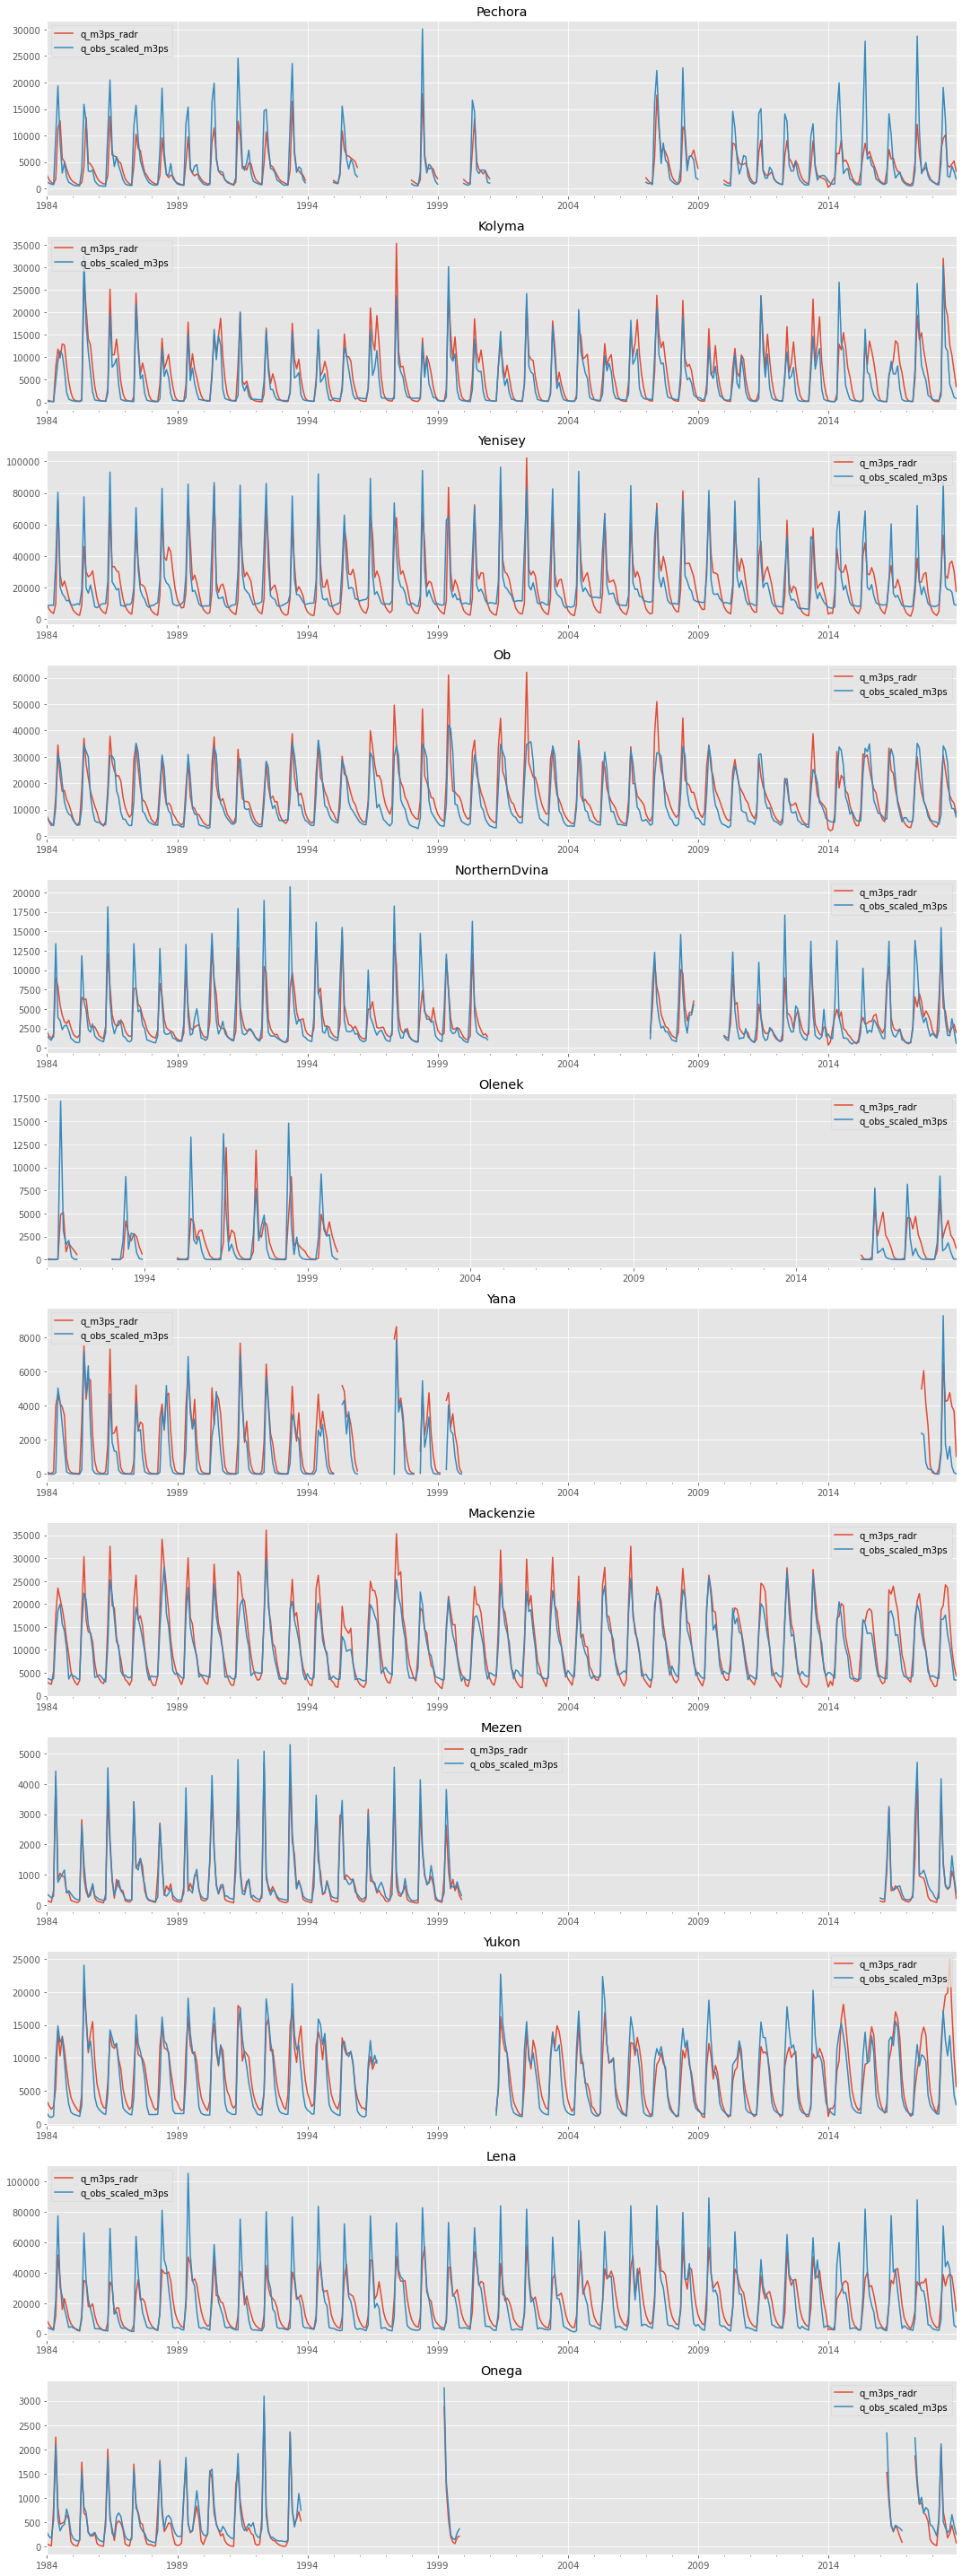

In [19]:
# Resample to monthly and plot time series
monthly_dict = {}  # Key: site

fig, axes = plt.subplots(nrows=len(rivers_li), ncols=1, figsize=(15, 40))

for idx, site in enumerate(rivers_li):

    df2 = df.loc[df['site'] == site, ['date', 'q_m3ps_radr', 'q_obs_scaled_m3ps']]
    df2 = df2.set_index('date')
    df2.index = pd.to_datetime(df2.index)

    monthly_df = df2.resample('M').agg(np.mean)

    monthly_dict[site] = monthly_df

    # Plot
    ax = axes[idx]
    monthly_df.plot(ax=ax)
    ax.set_title(site)
    ax.xaxis.label.set_visible(False)

plt.tight_layout()
plt.show()

# Plan for now

For now, decide to directly replace RADR data with ArcticGRO observations for the big 6 rivers. The Yukon has a data gap, so that data gap will be RADR rather than ArcticGRO.

Future improvements would be to explore:
* Bias-correcting RADR using observed data for all the other rivers. Some kind of month-by-month correction factor.
* Also replacing RADR data with observations, when available

If time allows, then I'll come back to this.

Therefore the only thing left to do in this notebook is to save the area-scaled monthly Arctic-GRO data for use in the next (and final) notebook, where we pull all the discharge data together into one file.

# Save area-scaled observed Q?

Did originally, but have removed that, as the data here is only for the time span that overlaps with RADR data. i.e. chops off the first and last years of the record (1980-1983, 2019).